In [50]:
from rdkit import rdBase
rdBase.rdkitVersion

'2018.09.3'

In [51]:
import glob
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

import pandas as pd
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt

In [52]:
path_to_library = '../FragmentLibrary'

# list of folders for each subpocket
folders = glob.glob(path_to_library+'/*')
subpockets = [folder[-2:] for folder in folders]
subpockets

['FP', 'B2', 'AP', 'SE', 'B1', 'GA']

In [53]:
# read data

data = pd.DataFrame()

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = PandasTools.LoadSDF(file, includeFingerprints=True, embedProps=True)
        
    fragments = []
    fingerprints = []
    smiles = []

    for frag in df.ROMol:
        # remove dummy atoms from fragments and create smiles
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        # 2D coordinates
        tmp = AllChem.Compute2DCoords(fixed_frag)
        fragments.append(fixed_frag)
        # smiles for drawing fragment
        smiles.append(Chem.MolToSmiles(fixed_frag))
        # fingerprint of fragment
        fingerprints.append(rdkit_gen.GetFingerprint(fixed_frag))
     
    df['smiles'] = smiles
    df['fragment'] = fragments
    df['fingerprint'] = fingerprints
    df['subpocket'] = subpocket
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(7529, 11)

In [54]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

For each subpocket, show:
* Number of fragments
* Number of unique fragments
* Fragments with highest number of occurences

### Adenine Pocket

In [55]:
n_frags = df_AP.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_AP.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  2671
Number of unique fragments:  1236


AP fragments with highest number of occurences:


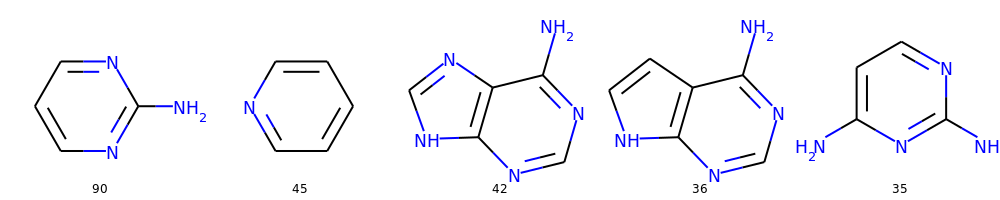

In [56]:
print('AP fragments with highest number of occurences:')

frag_counts = df_AP.smiles.value_counts()[:5]
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max, legends=[str(x) for x in frag_counts], molsPerRow=5)

### Front pocket

In [57]:
n_frags = df_FP.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_FP.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  1811
Number of unique fragments:  859


FP fragments with highest number of occurences:


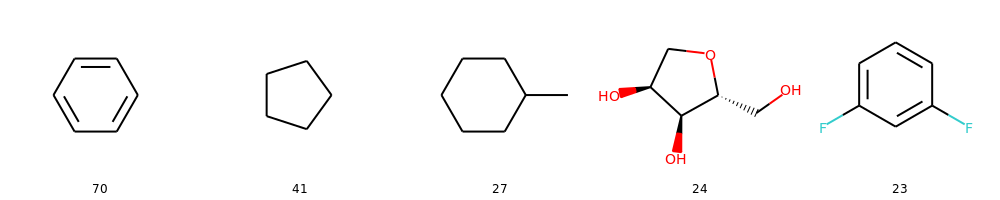

In [58]:
print('FP fragments with highest number of occurences:')

frag_counts = df_FP.smiles.value_counts()[:5]
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max, legends=[str(x) for x in frag_counts], molsPerRow=5)

### SE pocket

In [59]:
n_frags = df_SE.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_SE.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  1488
Number of unique fragments:  637


SE fragments with highest number of occurences:


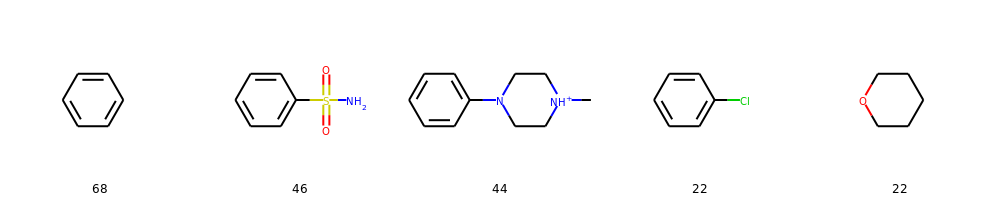

In [60]:
print('SE fragments with highest number of occurences:')

frag_counts = df_SE.smiles.value_counts()[:5]
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max, legends=[str(x) for x in frag_counts], molsPerRow=5)

### Gate area

In [61]:
n_frags = df_GA.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_GA.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  1202
Number of unique fragments:  433


GA fragments with highest number of occurences:


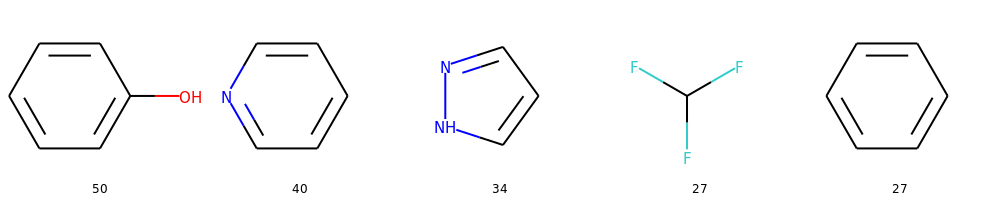

In [62]:
print('GA fragments with highest number of occurences:')

frag_counts = df_GA.smiles.value_counts()[:5]
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max, legends=[str(x) for x in frag_counts], molsPerRow=5)

### Back pocket I

In [63]:
n_frags = df_B1.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_B1.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  112
Number of unique fragments:  52


B1 fragments with highest number of occurences:


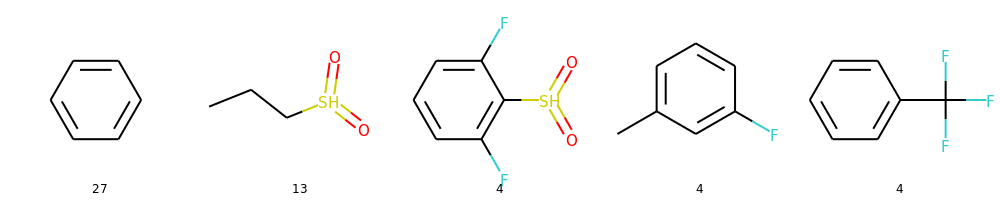

In [64]:
print('B1 fragments with highest number of occurences:')

frag_counts = df_B1.smiles.value_counts()[:5]
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max, legends=[str(x) for x in frag_counts], molsPerRow=5)

### Back pocket II

In [65]:
n_frags = df_B2.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_B2.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  245
Number of unique fragments:  124


FP fragments with highest number of occurences:


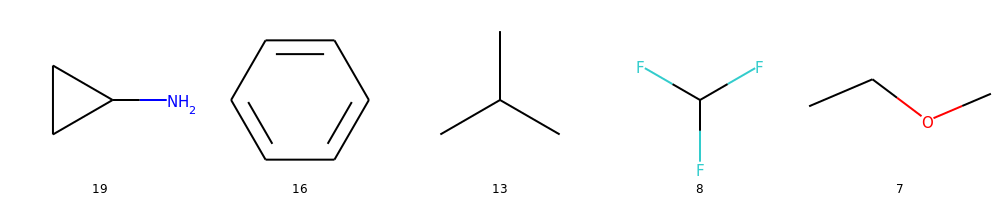

In [66]:
print('FP fragments with highest number of occurences:')

frag_counts = df_B2.smiles.value_counts()[:5]
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max, legends=[str(x) for x in frag_counts], molsPerRow=5)

Functions needed for Clustering:

In [67]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    fp_list = list(fp_list)
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [68]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps, cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [69]:
def analyze_clusters(clusters, subpocket, cutoff):
    
    # Give a short report about the numbers of clusters and their sizes
    num_clust_g1 = len([c for c in clusters if len(c) == 1])
    num_clust_g5 = len([c for c in clusters if len(c) > 5])
    num_clust_g25 = len([c for c in clusters if len(c) > 25])
    num_clust_g100 = len([c for c in clusters if len(c) > 100])

    print(subpocket)
    print("Threshold: ", cutoff)
    print("total # clusters: ", len(clusters))
    print("# clusters with only 1 compound: ", num_clust_g1)
    print("# clusters with >5 compounds: ", num_clust_g5)
    print("# clusters with >25 compounds: ", num_clust_g25)
    print("# clusters with >100 compounds: ", num_clust_g100)

    # Plot the size of the clusters
    fig = plt.figure(1, figsize=(8, 3))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %cutoff), fontsize=10)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

    return None


## Butina Clustering for each subpocket with different cutoffs:

AP
Threshold:  0.0
total # clusters:  1201
# clusters with only 1 compound:  820
# clusters with >5 compounds:  78
# clusters with >25 compounds:  7
# clusters with >100 compounds:  0


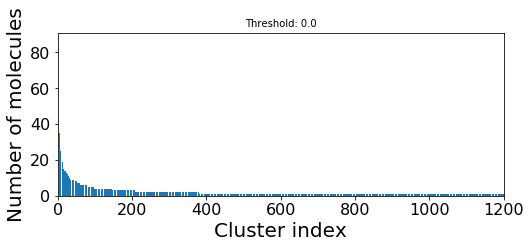

AP
Threshold:  0.1
total # clusters:  1124
# clusters with only 1 compound:  738
# clusters with >5 compounds:  89
# clusters with >25 compounds:  7
# clusters with >100 compounds:  0


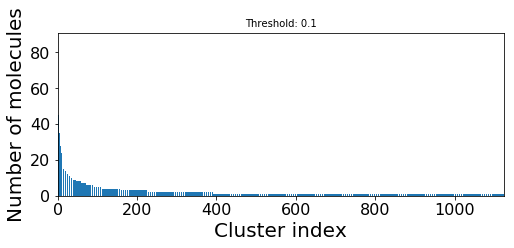

AP
Threshold:  0.2
total # clusters:  921
# clusters with only 1 compound:  563
# clusters with >5 compounds:  99
# clusters with >25 compounds:  9
# clusters with >100 compounds:  0


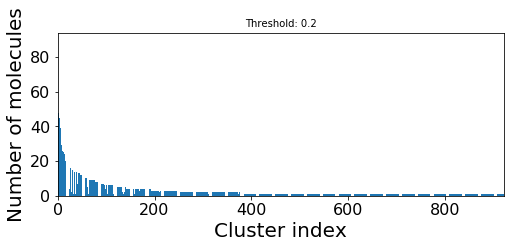

AP
Threshold:  0.30000000000000004
total # clusters:  728
# clusters with only 1 compound:  411
# clusters with >5 compounds:  97
# clusters with >25 compounds:  11
# clusters with >100 compounds:  1


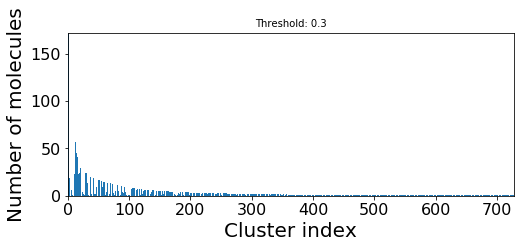

AP
Threshold:  0.4
total # clusters:  563
# clusters with only 1 compound:  298
# clusters with >5 compounds:  96
# clusters with >25 compounds:  18
# clusters with >100 compounds:  2


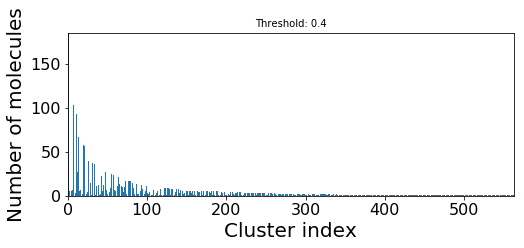

AP
Threshold:  0.5
total # clusters:  393
# clusters with only 1 compound:  183
# clusters with >5 compounds:  84
# clusters with >25 compounds:  18
# clusters with >100 compounds:  5


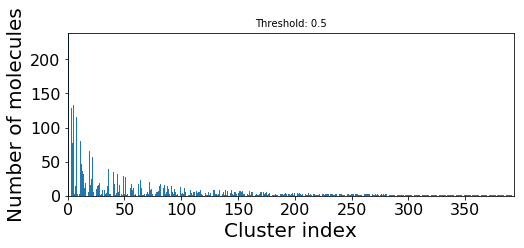

AP
Threshold:  0.6000000000000001
total # clusters:  230
# clusters with only 1 compound:  93
# clusters with >5 compounds:  66
# clusters with >25 compounds:  20
# clusters with >100 compounds:  6


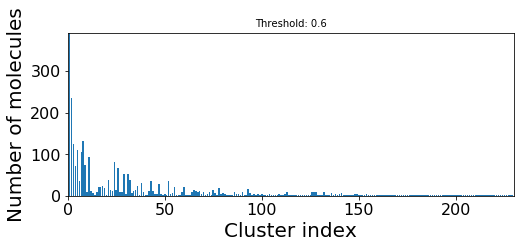

AP
Threshold:  0.7000000000000001
total # clusters:  121
# clusters with only 1 compound:  44
# clusters with >5 compounds:  45
# clusters with >25 compounds:  19
# clusters with >100 compounds:  3


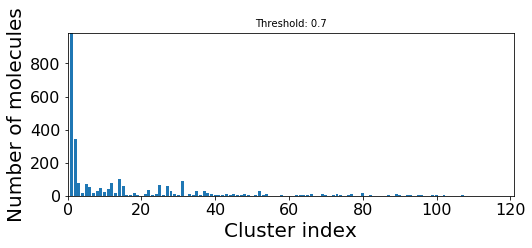

AP
Threshold:  0.8
total # clusters:  44
# clusters with only 1 compound:  12
# clusters with >5 compounds:  16
# clusters with >25 compounds:  8
# clusters with >100 compounds:  4


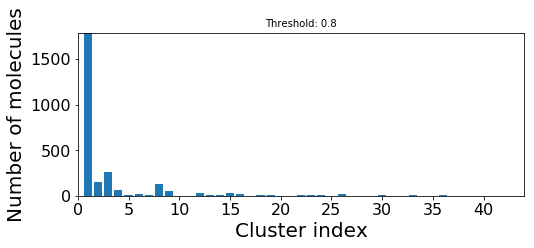

AP
Threshold:  0.9
total # clusters:  11
# clusters with only 1 compound:  2
# clusters with >5 compounds:  6
# clusters with >25 compounds:  2
# clusters with >100 compounds:  1


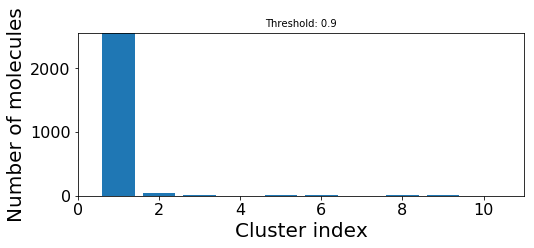

In [70]:
# cluster adenine pocket
fps = df_AP.fingerprint
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, 'AP', cutoff=i)

FP
Threshold:  0.0
total # clusters:  787
# clusters with only 1 compound:  530
# clusters with >5 compounds:  57
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


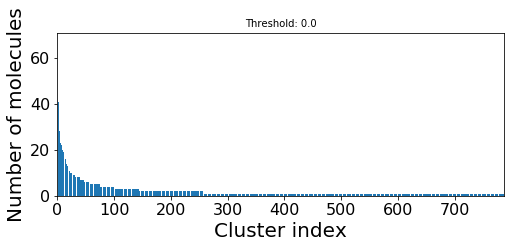

FP
Threshold:  0.1
total # clusters:  760
# clusters with only 1 compound:  498
# clusters with >5 compounds:  58
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


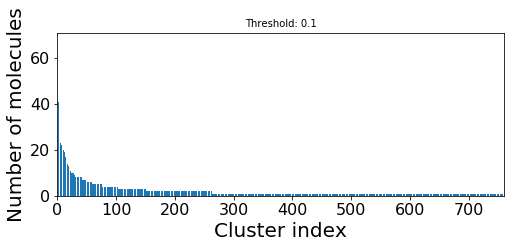

FP
Threshold:  0.2
total # clusters:  688
# clusters with only 1 compound:  422
# clusters with >5 compounds:  66
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


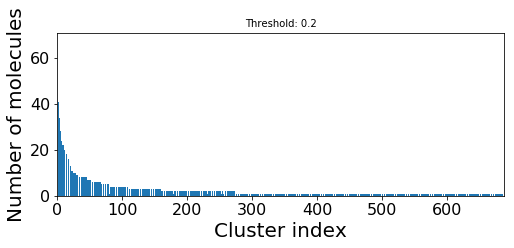

FP
Threshold:  0.30000000000000004
total # clusters:  568
# clusters with only 1 compound:  313
# clusters with >5 compounds:  62
# clusters with >25 compounds:  12
# clusters with >100 compounds:  0


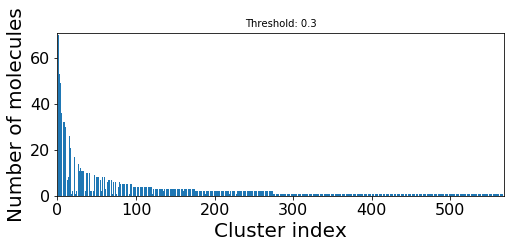

FP
Threshold:  0.4
total # clusters:  441
# clusters with only 1 compound:  214
# clusters with >5 compounds:  68
# clusters with >25 compounds:  12
# clusters with >100 compounds:  0


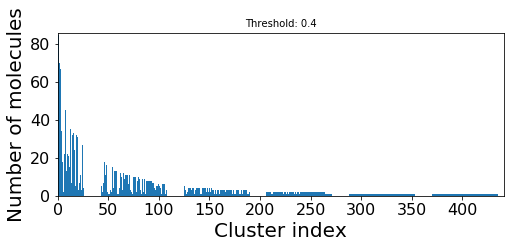

FP
Threshold:  0.5
total # clusters:  306
# clusters with only 1 compound:  136
# clusters with >5 compounds:  63
# clusters with >25 compounds:  13
# clusters with >100 compounds:  2


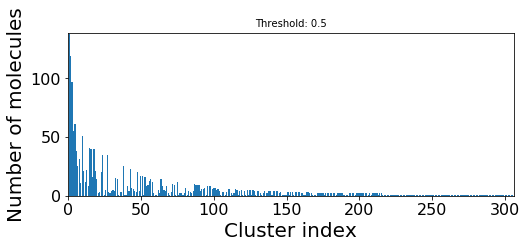

FP
Threshold:  0.6000000000000001
total # clusters:  221
# clusters with only 1 compound:  79
# clusters with >5 compounds:  58
# clusters with >25 compounds:  16
# clusters with >100 compounds:  3


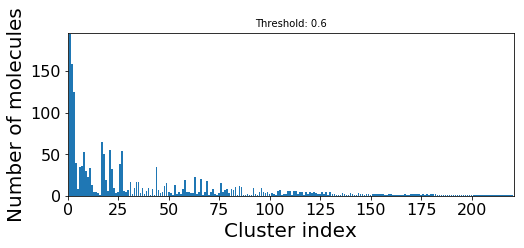

FP
Threshold:  0.7000000000000001
total # clusters:  105
# clusters with only 1 compound:  26
# clusters with >5 compounds:  48
# clusters with >25 compounds:  13
# clusters with >100 compounds:  4


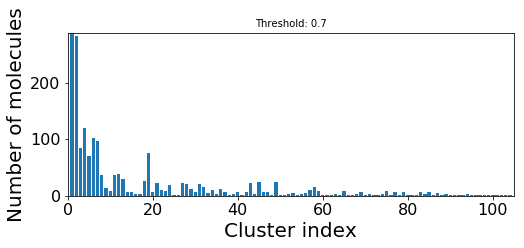

FP
Threshold:  0.8
total # clusters:  51
# clusters with only 1 compound:  10
# clusters with >5 compounds:  25
# clusters with >25 compounds:  8
# clusters with >100 compounds:  5


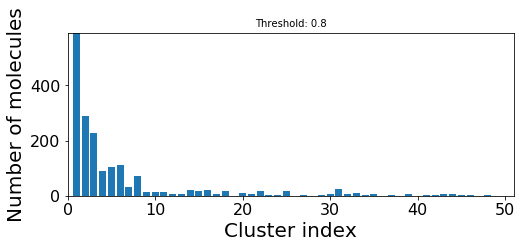

FP
Threshold:  0.9
total # clusters:  15
# clusters with only 1 compound:  3
# clusters with >5 compounds:  10
# clusters with >25 compounds:  4
# clusters with >100 compounds:  2


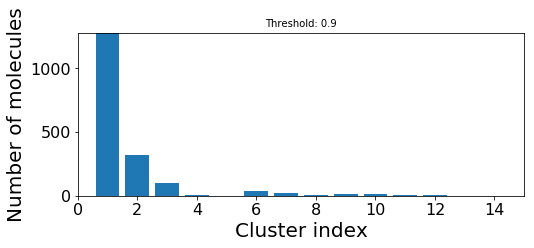

In [71]:
# cluster front pocket
fps = df_FP.fingerprint
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, 'FP', cutoff=i)

SE
Threshold:  0.0
total # clusters:  608
# clusters with only 1 compound:  406
# clusters with >5 compounds:  46
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


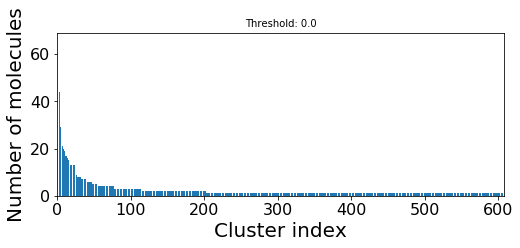

SE
Threshold:  0.1
total # clusters:  576
# clusters with only 1 compound:  376
# clusters with >5 compounds:  46
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


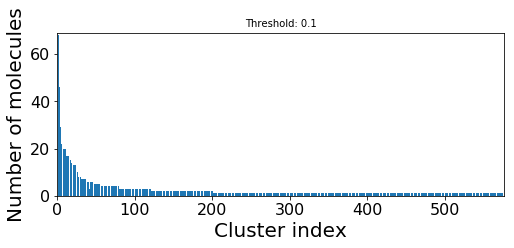

SE
Threshold:  0.2
total # clusters:  492
# clusters with only 1 compound:  302
# clusters with >5 compounds:  51
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


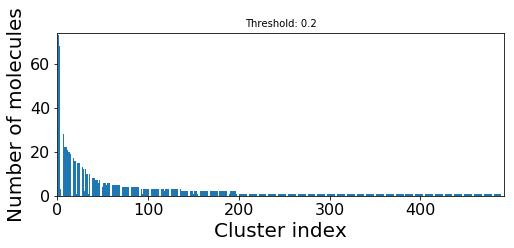

SE
Threshold:  0.30000000000000004
total # clusters:  410
# clusters with only 1 compound:  236
# clusters with >5 compounds:  49
# clusters with >25 compounds:  7
# clusters with >100 compounds:  0


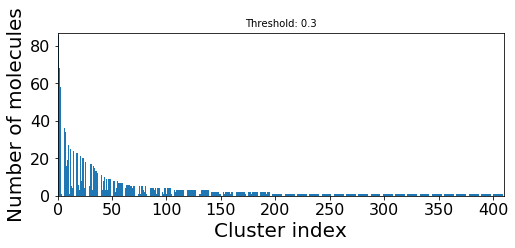

SE
Threshold:  0.4
total # clusters:  307
# clusters with only 1 compound:  157
# clusters with >5 compounds:  50
# clusters with >25 compounds:  13
# clusters with >100 compounds:  1


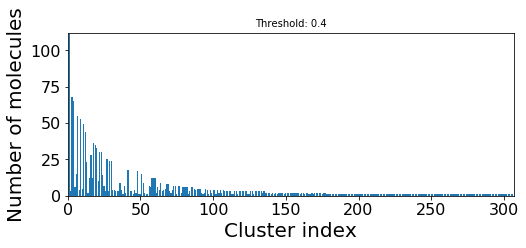

SE
Threshold:  0.5
total # clusters:  213
# clusters with only 1 compound:  90
# clusters with >5 compounds:  43
# clusters with >25 compounds:  14
# clusters with >100 compounds:  2


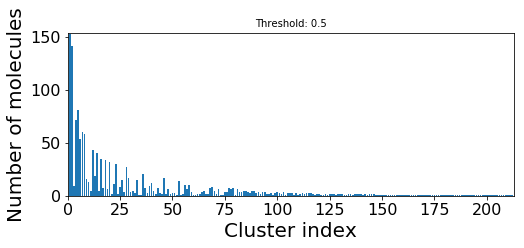

SE
Threshold:  0.6000000000000001
total # clusters:  149
# clusters with only 1 compound:  59
# clusters with >5 compounds:  40
# clusters with >25 compounds:  13
# clusters with >100 compounds:  3


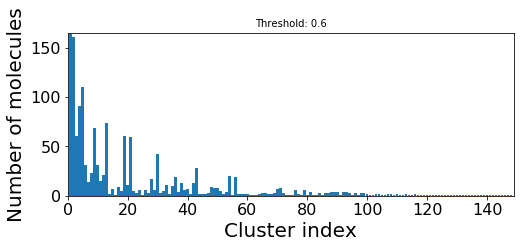

SE
Threshold:  0.7000000000000001
total # clusters:  87
# clusters with only 1 compound:  30
# clusters with >5 compounds:  27
# clusters with >25 compounds:  14
# clusters with >100 compounds:  4


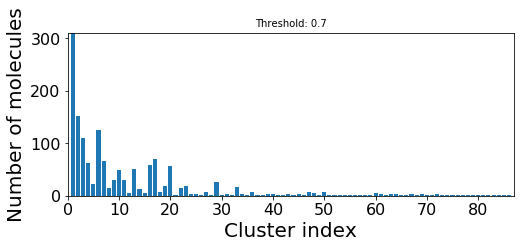

SE
Threshold:  0.8
total # clusters:  39
# clusters with only 1 compound:  7
# clusters with >5 compounds:  18
# clusters with >25 compounds:  10
# clusters with >100 compounds:  4


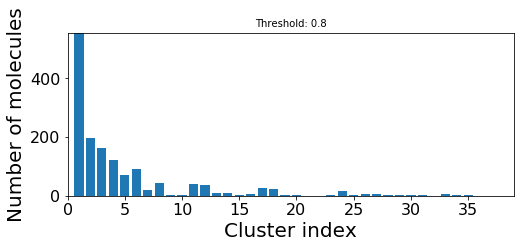

SE
Threshold:  0.9
total # clusters:  14
# clusters with only 1 compound:  3
# clusters with >5 compounds:  6
# clusters with >25 compounds:  6
# clusters with >100 compounds:  1


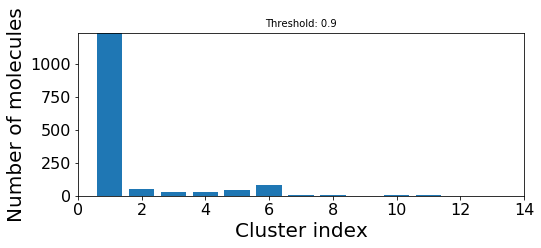

In [72]:
# cluster solvent exposed pocket
fps = df_SE.fingerprint
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, 'SE', cutoff=i)

GA
Threshold:  0.0
total # clusters:  424
# clusters with only 1 compound:  264
# clusters with >5 compounds:  43
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


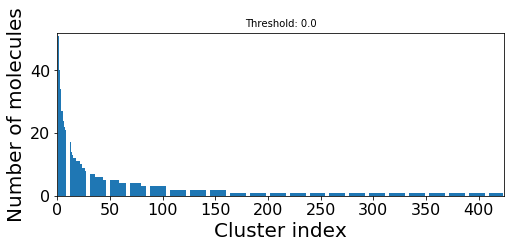

GA
Threshold:  0.1
total # clusters:  414
# clusters with only 1 compound:  250
# clusters with >5 compounds:  44
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


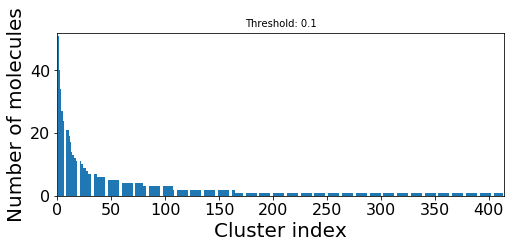

GA
Threshold:  0.2
total # clusters:  359
# clusters with only 1 compound:  205
# clusters with >5 compounds:  49
# clusters with >25 compounds:  6
# clusters with >100 compounds:  0


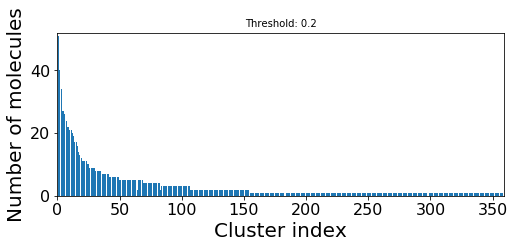

GA
Threshold:  0.30000000000000004
total # clusters:  299
# clusters with only 1 compound:  161
# clusters with >5 compounds:  48
# clusters with >25 compounds:  11
# clusters with >100 compounds:  0


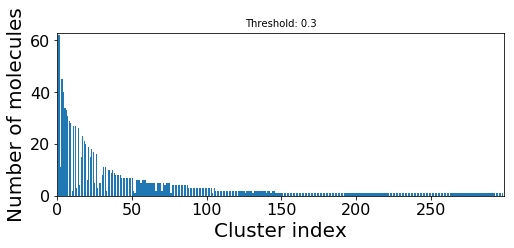

GA
Threshold:  0.4
total # clusters:  243
# clusters with only 1 compound:  120
# clusters with >5 compounds:  50
# clusters with >25 compounds:  9
# clusters with >100 compounds:  1


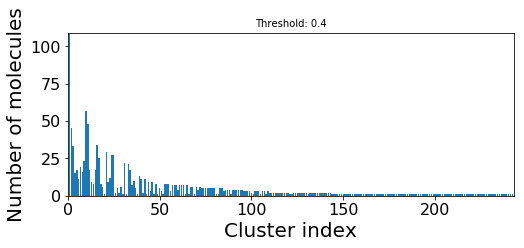

GA
Threshold:  0.5
total # clusters:  180
# clusters with only 1 compound:  85
# clusters with >5 compounds:  36
# clusters with >25 compounds:  12
# clusters with >100 compounds:  1


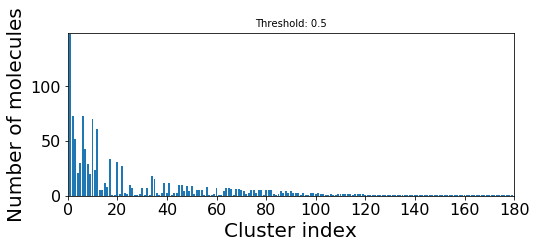

GA
Threshold:  0.6000000000000001
total # clusters:  118
# clusters with only 1 compound:  50
# clusters with >5 compounds:  36
# clusters with >25 compounds:  10
# clusters with >100 compounds:  2


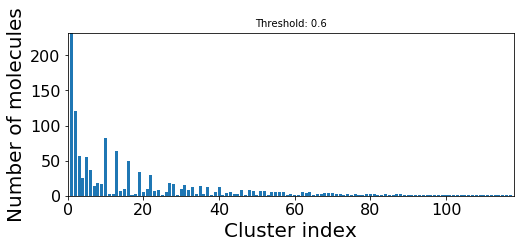

GA
Threshold:  0.7000000000000001
total # clusters:  77
# clusters with only 1 compound:  24
# clusters with >5 compounds:  28
# clusters with >25 compounds:  9
# clusters with >100 compounds:  3


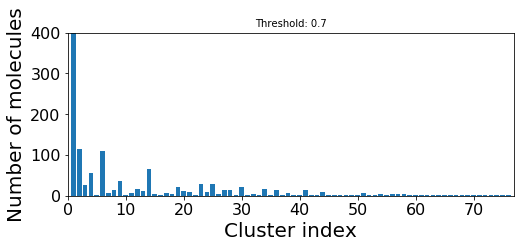

GA
Threshold:  0.8
total # clusters:  35
# clusters with only 1 compound:  5
# clusters with >5 compounds:  21
# clusters with >25 compounds:  8
# clusters with >100 compounds:  3


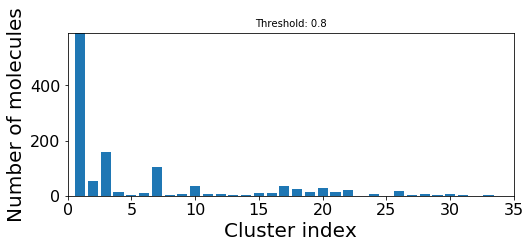

GA
Threshold:  0.9
total # clusters:  11
# clusters with only 1 compound:  1
# clusters with >5 compounds:  8
# clusters with >25 compounds:  4
# clusters with >100 compounds:  1


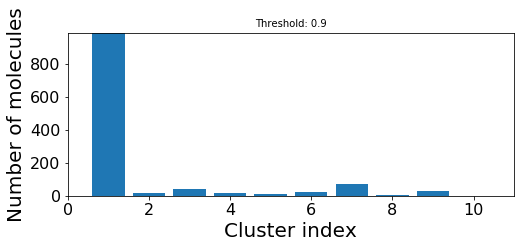

In [73]:
# cluster gate area
fps = df_GA.fingerprint
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, 'GA', cutoff=i)

B1
Threshold:  0.0
total # clusters:  52
# clusters with only 1 compound:  37
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


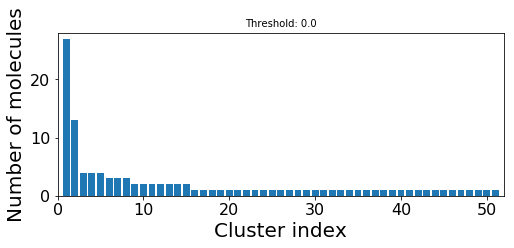

B1
Threshold:  0.1
total # clusters:  52
# clusters with only 1 compound:  37
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


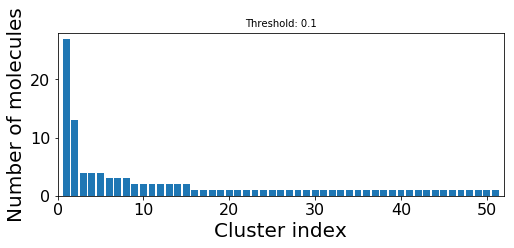

B1
Threshold:  0.2
total # clusters:  50
# clusters with only 1 compound:  34
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


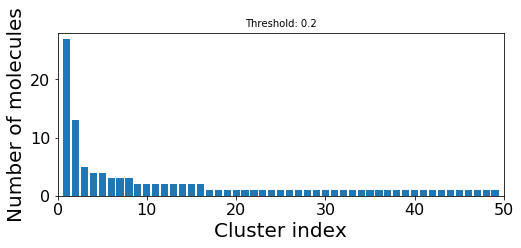

B1
Threshold:  0.30000000000000004
total # clusters:  45
# clusters with only 1 compound:  25
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


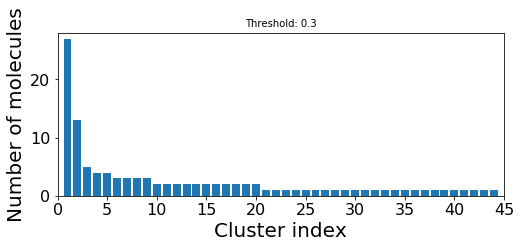

B1
Threshold:  0.4
total # clusters:  39
# clusters with only 1 compound:  23
# clusters with >5 compounds:  5
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


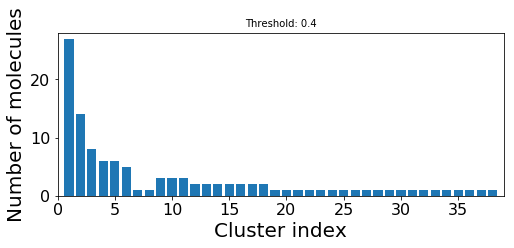

B1
Threshold:  0.5
total # clusters:  33
# clusters with only 1 compound:  19
# clusters with >5 compounds:  5
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


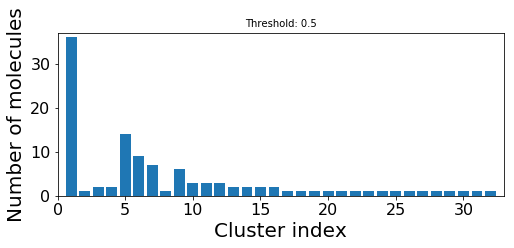

B1
Threshold:  0.6000000000000001
total # clusters:  31
# clusters with only 1 compound:  16
# clusters with >5 compounds:  4
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


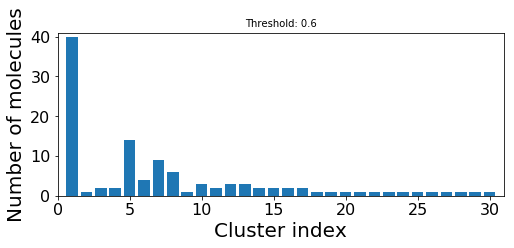

B1
Threshold:  0.7000000000000001
total # clusters:  21
# clusters with only 1 compound:  11
# clusters with >5 compounds:  4
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


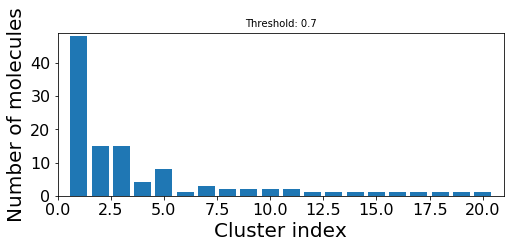

B1
Threshold:  0.8
total # clusters:  18
# clusters with only 1 compound:  6
# clusters with >5 compounds:  4
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


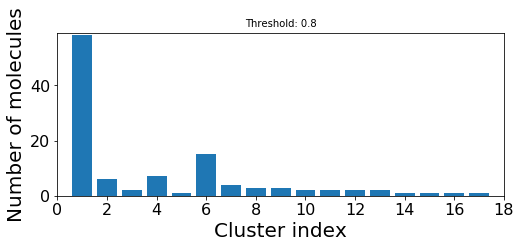

B1
Threshold:  0.9
total # clusters:  8
# clusters with only 1 compound:  3
# clusters with >5 compounds:  3
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


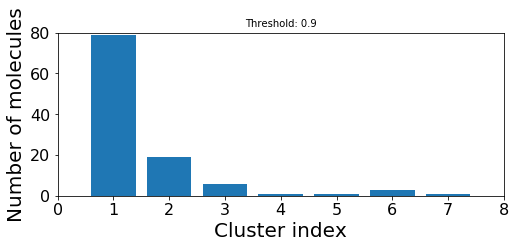

In [74]:
# cluster back pocket I
fps = df_B1.fingerprint
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, 'B1', cutoff=i)

B2
Threshold:  0.0
total # clusters:  122
# clusters with only 1 compound:  82
# clusters with >5 compounds:  7
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


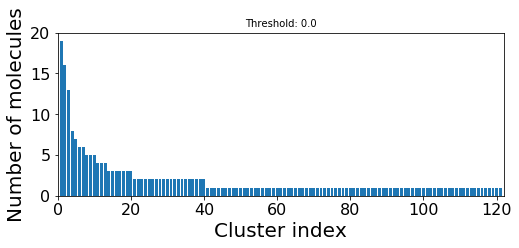

B2
Threshold:  0.1
total # clusters:  119
# clusters with only 1 compound:  78
# clusters with >5 compounds:  7
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


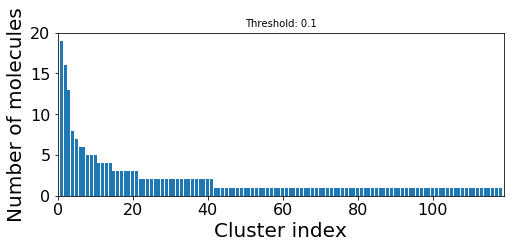

B2
Threshold:  0.2
total # clusters:  112
# clusters with only 1 compound:  69
# clusters with >5 compounds:  8
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


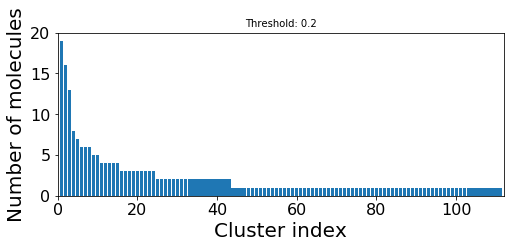

B2
Threshold:  0.30000000000000004
total # clusters:  101
# clusters with only 1 compound:  58
# clusters with >5 compounds:  10
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


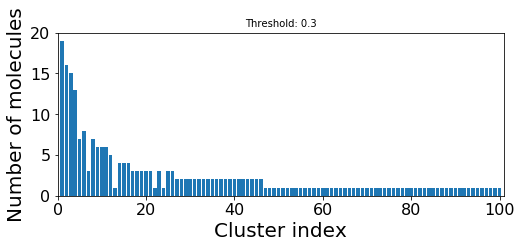

B2
Threshold:  0.4
total # clusters:  86
# clusters with only 1 compound:  41
# clusters with >5 compounds:  10
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


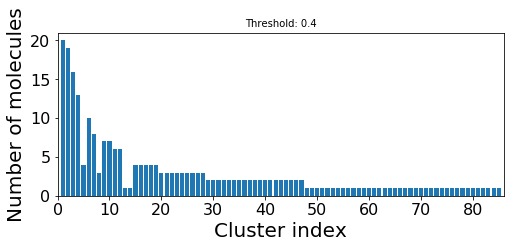

B2
Threshold:  0.5
total # clusters:  72
# clusters with only 1 compound:  31
# clusters with >5 compounds:  10
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


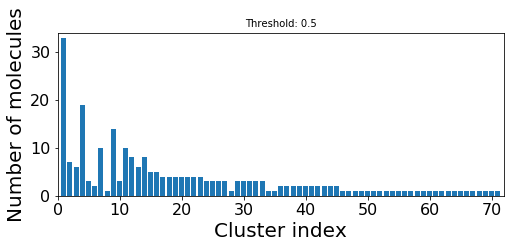

B2
Threshold:  0.6000000000000001
total # clusters:  59
# clusters with only 1 compound:  21
# clusters with >5 compounds:  11
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


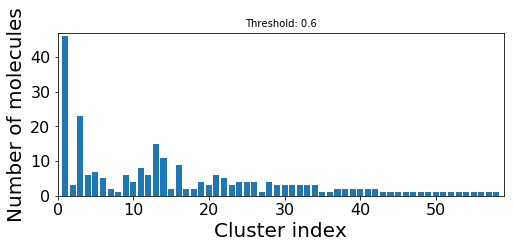

B2
Threshold:  0.7000000000000001
total # clusters:  35
# clusters with only 1 compound:  7
# clusters with >5 compounds:  10
# clusters with >25 compounds:  2
# clusters with >100 compounds:  0


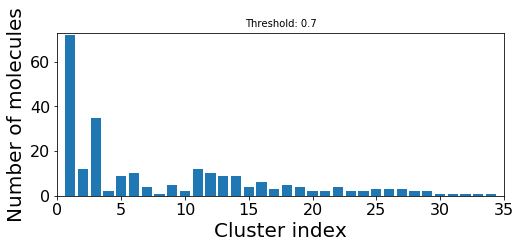

B2
Threshold:  0.8
total # clusters:  24
# clusters with only 1 compound:  7
# clusters with >5 compounds:  8
# clusters with >25 compounds:  2
# clusters with >100 compounds:  1


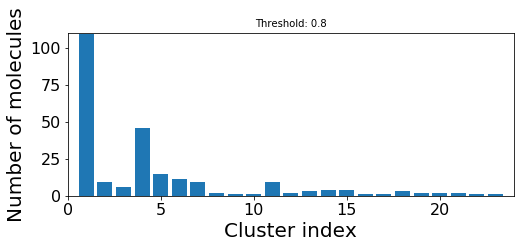

B2
Threshold:  0.9
total # clusters:  10
# clusters with only 1 compound:  2
# clusters with >5 compounds:  6
# clusters with >25 compounds:  1
# clusters with >100 compounds:  1


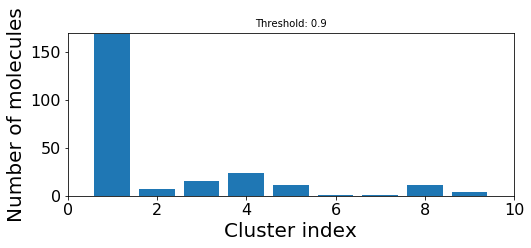

In [75]:
# cluster back pocket II
fps = df_B2.fingerprint
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, 'B2', cutoff=i)

## Investigate clusters:

In [76]:
def principal_components(X):
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    X = pca.transform(X)
    return [p[0] for p in X], [p[1] for p in X]

In [77]:
def find_cluster_mcs(cluster, frags):
    frags = list(frags)
    mols = [frags[i] for i in cluster]
    mcs = rdFMCS.FindMCS(mols, threshold=0.8)
    substructure = Chem.MolFromSmarts(mcs.smartsString)
    return substructure

In [78]:
def cluster_scatter_plots(x, y, clusters, n_clusters, df, subpocket):
    
    X, Y = [], []
    kinases = list(df.kinase)
    kinasesXY = []
    cluster_colors = []#np.empty(len(points), dtype=object)
    for p, point in enumerate(x):
        for c, cluster in enumerate(clusters[:n_clusters]):
            if p in cluster:
                cluster_colors.append(c)
                X.append(point)
                Y.append(y[p])
                kinasesXY.append(kinases[p])

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(X, Y, c=cluster_colors, s=20, cmap='brg')
    plt.title(str(n_clusters)+' largest clusters in '+subpocket+' colored by cluster')

    # find kinase colors
    kinase_set = list(set(kinasesXY))
    kinase_colors = []
    for k, kinase in enumerate(kinasesXY):
        kinase_colors.append(kinase_set.index(kinase))

    plt.subplot(1,2,2)
    plt.scatter(X, Y, c=kinase_colors, s=20, cmap='brg')
    plt.title(str(n_clusters)+' largest clusters in '+subpocket+' colored by kinase')
    plt.show()
    
    return None

## ADENINE POCKET:

AP
Threshold:  0.5
total # clusters:  393
# clusters with only 1 compound:  183
# clusters with >5 compounds:  84
# clusters with >25 compounds:  18
# clusters with >100 compounds:  5


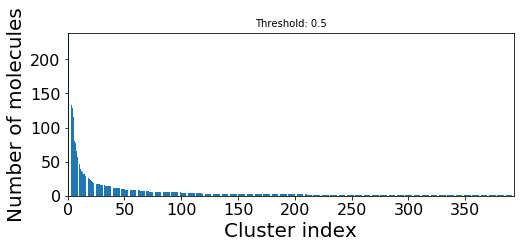

Total number of fragments:  2671


In [79]:
# investigate adenine pocket clusters
cutoff = 0.5
fps = df_AP.fingerprint
frags = df_AP.fragment

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, 'AP', cutoff)

print('Total number of fragments: ', len(frags))

In [80]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

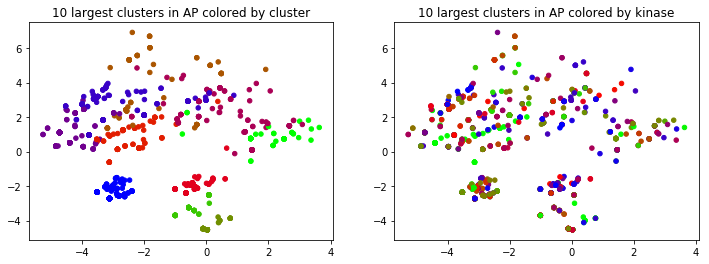

In [81]:
# plot clusters
n_clusters = 10
cluster_scatter_plots(x, y, clusters, n_clusters, df_AP, 'AP')

Maximum common substructure per cluster: 


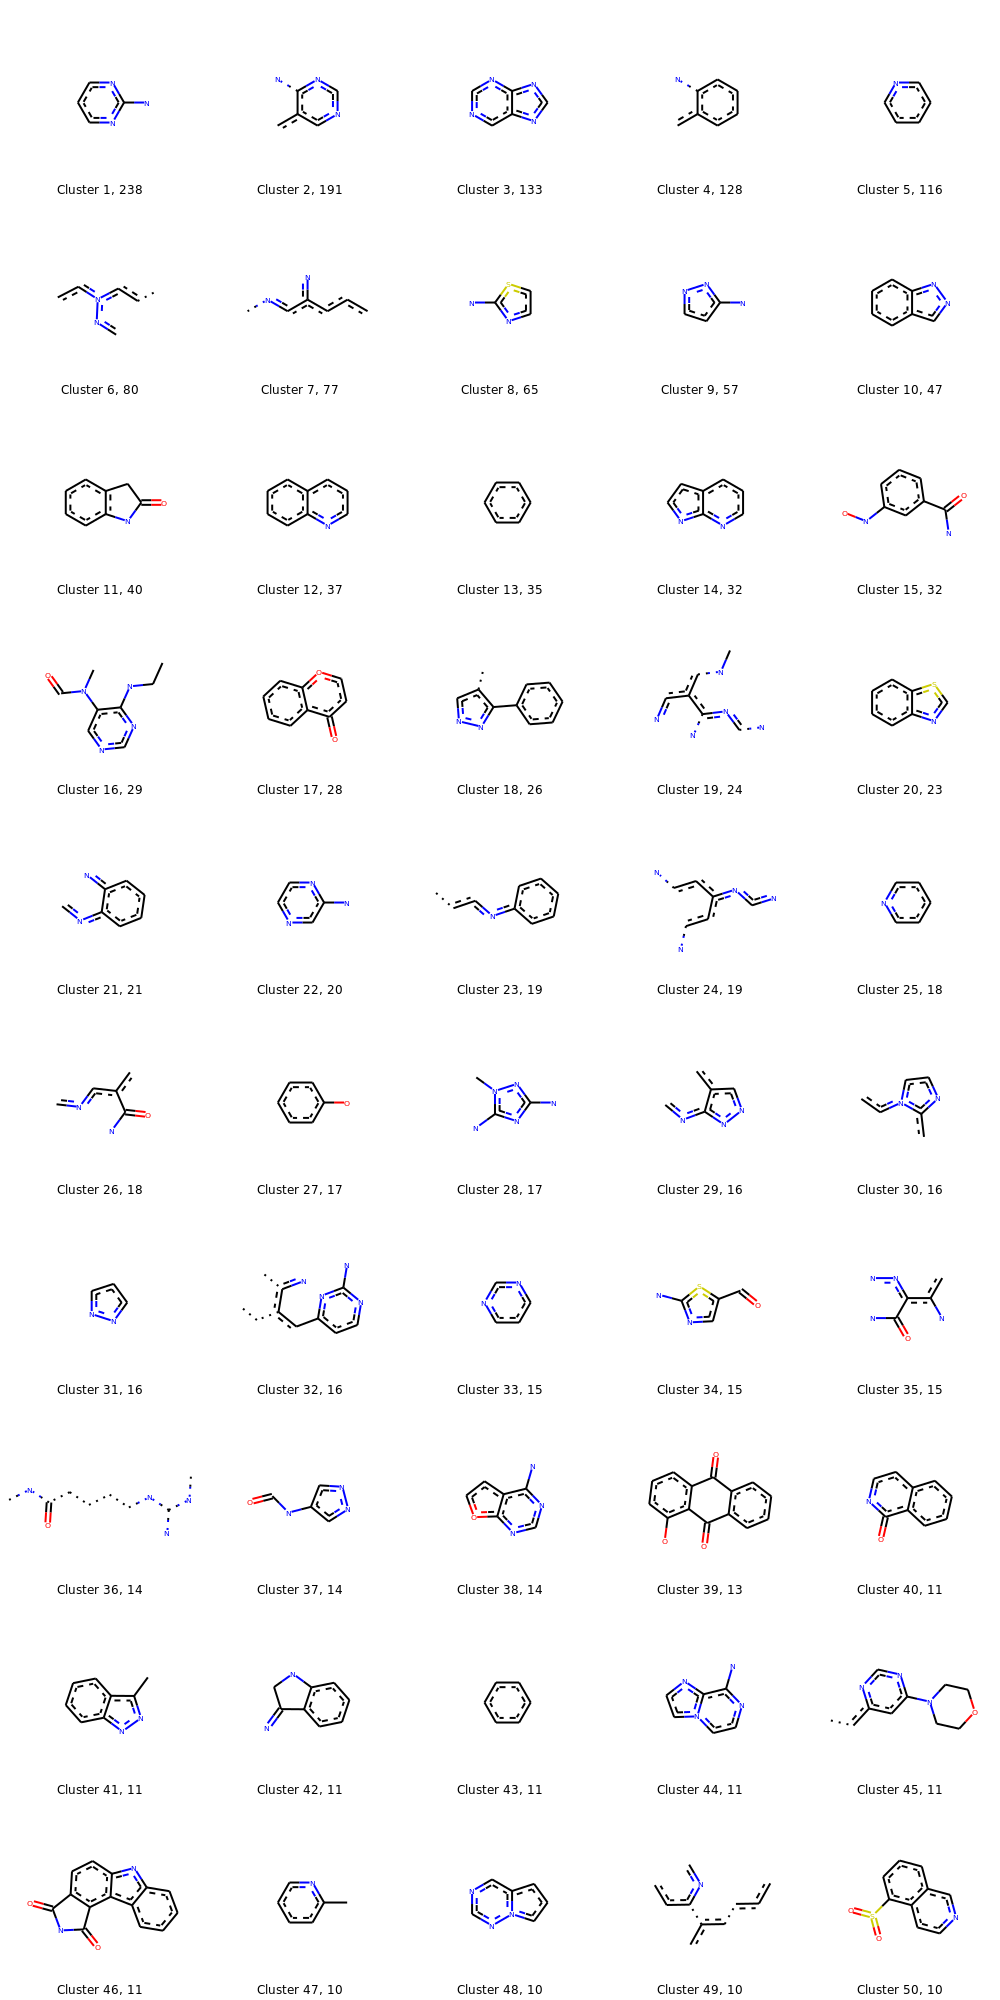

In [82]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:50]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
               
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## FRONT POCKET:

FP
Threshold:  0.5
total # clusters:  306
# clusters with only 1 compound:  136
# clusters with >5 compounds:  63
# clusters with >25 compounds:  13
# clusters with >100 compounds:  2


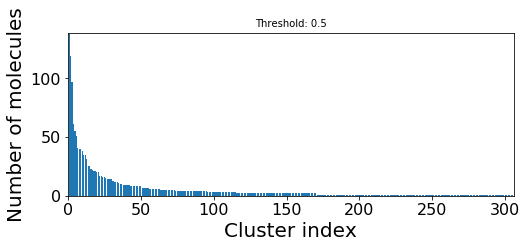

Total number of fragments:  1811


In [83]:
# investigate front pocket
cutoff = 0.5
fps = df_FP.fingerprint
frags = df_FP.fragment

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, 'FP', cutoff)

print('Total number of fragments: ', len(frags))

In [84]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

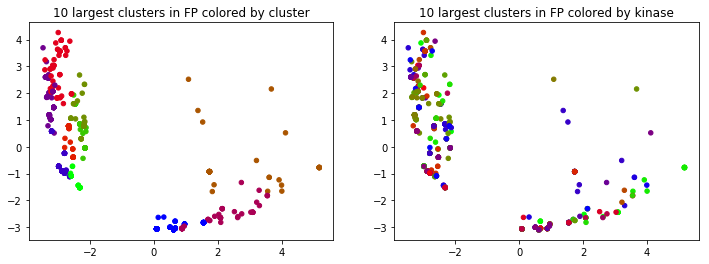

In [85]:
# plot clusters
n_clusters = 10
cluster_scatter_plots(x, y, clusters, n_clusters, df_FP, 'FP')

Maximum common substructure per cluster: 


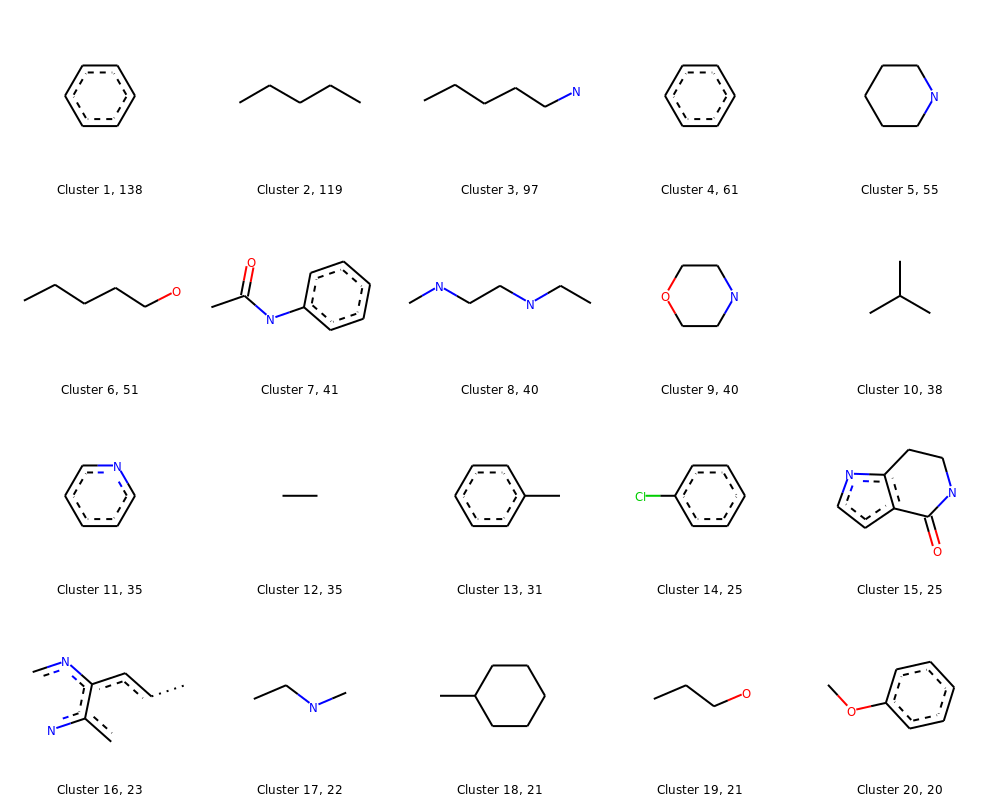

In [86]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:20]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## SE POCKET:

SE
Threshold:  0.5
total # clusters:  213
# clusters with only 1 compound:  90
# clusters with >5 compounds:  43
# clusters with >25 compounds:  14
# clusters with >100 compounds:  2


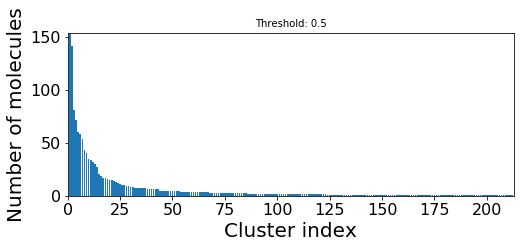

Total number of fragments:  1488


In [87]:
# investigate solvent exposed pocket
cutoff = 0.5
fps = df_SE.fingerprint
frags = df_SE.fragment

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, 'SE', cutoff)

print('Total number of fragments: ', len(frags))

In [88]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

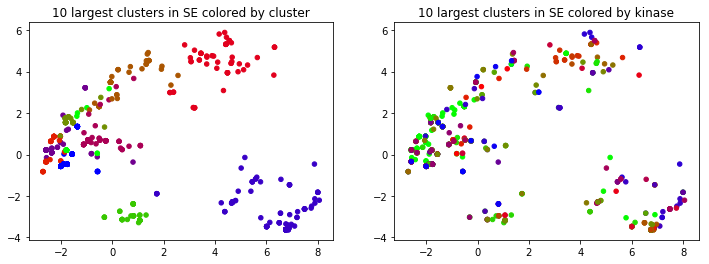

In [89]:
# plot clusters
n_clusters = 10
cluster_scatter_plots(x, y, clusters, n_clusters, df_SE, 'SE')

Maximum common substructure per cluster: 


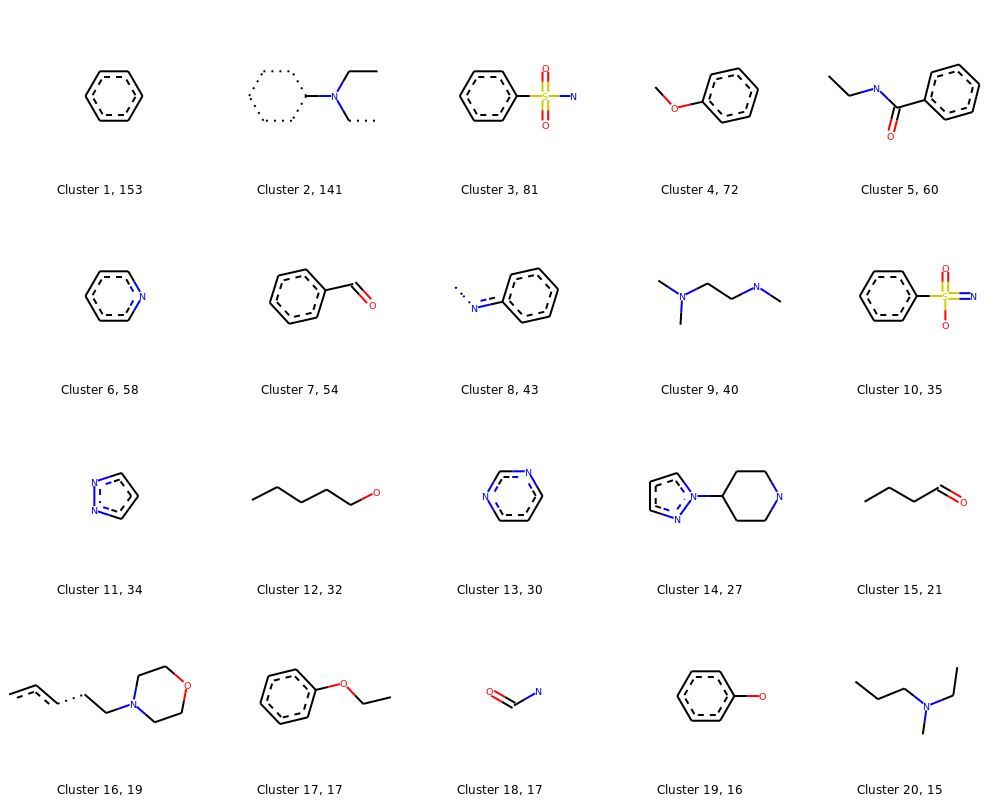

In [90]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:20]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## GATE AREA:

GA
Threshold:  0.5
total # clusters:  180
# clusters with only 1 compound:  85
# clusters with >5 compounds:  36
# clusters with >25 compounds:  12
# clusters with >100 compounds:  1


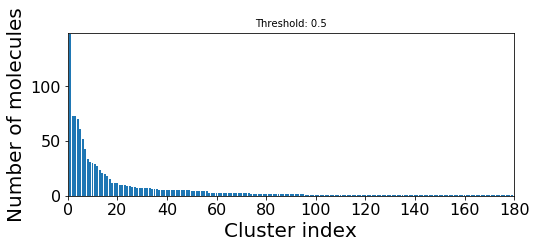

Total number of fragments:  1202


In [91]:
# investigate gate area
cutoff = 0.5
fps = df_GA.fingerprint
frags = df_GA.fragment

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, 'GA', cutoff)
print('Total number of fragments: ', len(frags))

In [92]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

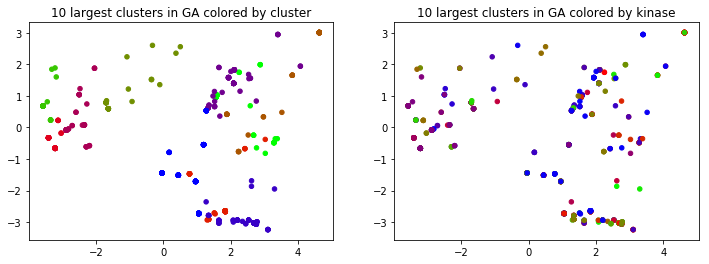

In [93]:
# plot clusters
n_clusters = 10
cluster_scatter_plots(x, y, clusters, n_clusters, df_GA, 'GA')

Maximum common substructure per cluster: 


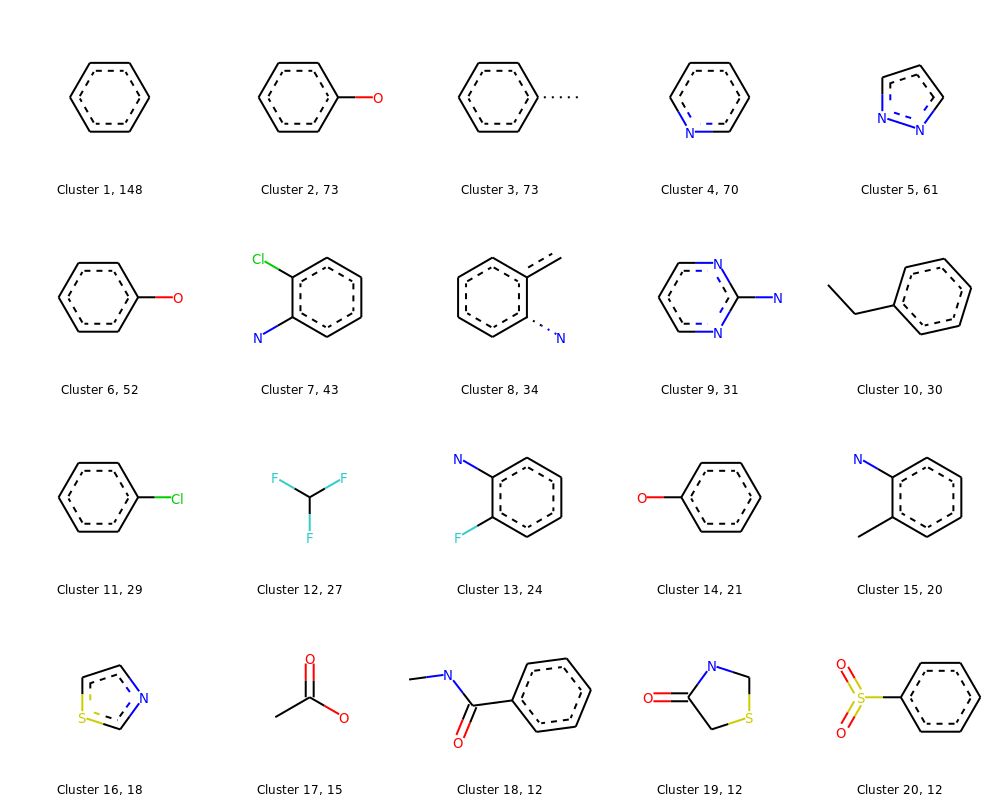

In [94]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:20]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## BACK POCKET I

B1
Threshold:  0.5
total # clusters:  33
# clusters with only 1 compound:  19
# clusters with >5 compounds:  5
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


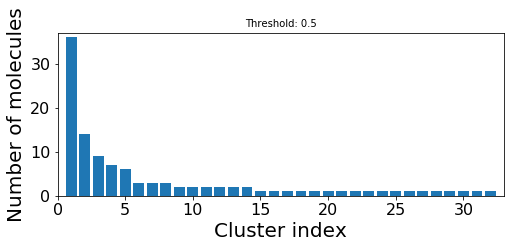

Total number of fragments:  245


In [95]:
# investigate back pocket I
cutoff = 0.5
fps = df_B1.fingerprint
frags = df_B2.fragment

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, 'B1', cutoff)
print('Total number of fragments: ', len(frags))

In [96]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

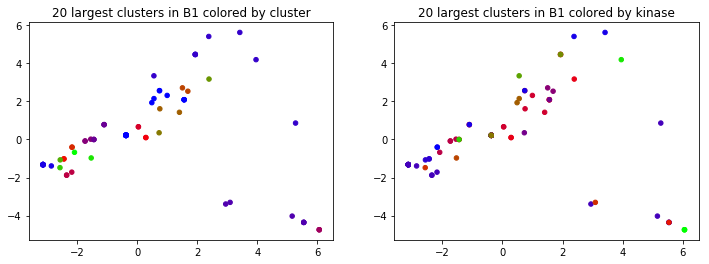

In [97]:
# plot clusters
n_clusters = 20
cluster_scatter_plots(x, y, clusters, n_clusters, df_B1, 'B1')

Maximum common substructure per cluster: 


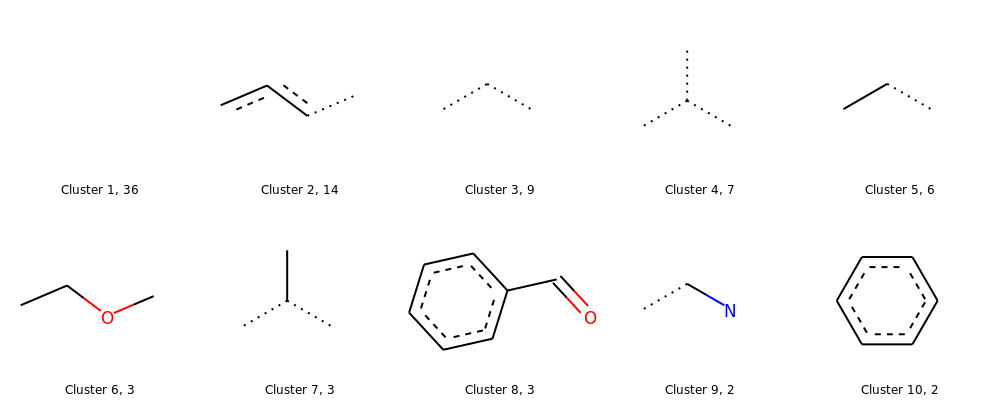

In [98]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:10]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## BACK POCKET II

B2
Threshold:  0.5
total # clusters:  72
# clusters with only 1 compound:  31
# clusters with >5 compounds:  10
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


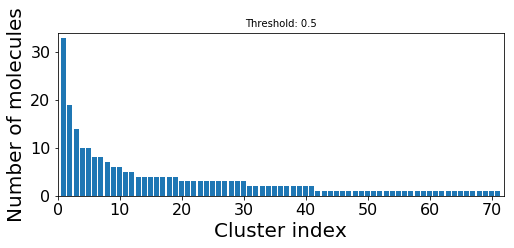

Total number of fragments:  245


In [99]:
# investigate back pocket II
cutoff = 0.5
fps = df_B2.fingerprint
frags = df_B2.fragment

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, 'B2', cutoff)
print('Total number of fragments: ', len(frags))

In [100]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

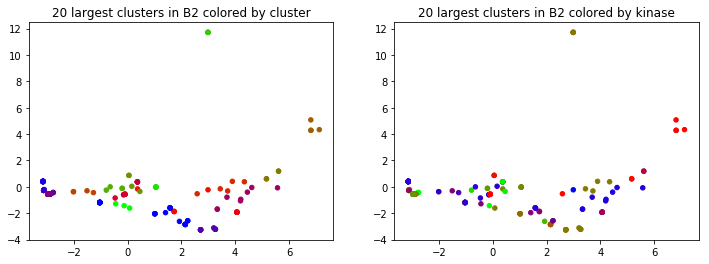

In [101]:
# plot clusters
n_clusters = 20
cluster_scatter_plots(x, y, clusters, n_clusters, df_B2, 'B2')

Maximum common substructure per cluster: 


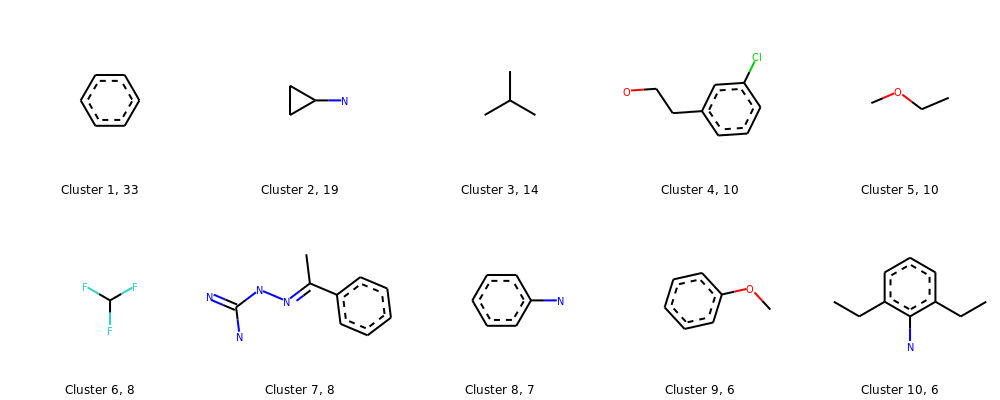

In [102]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:10]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)